<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_Project_Computer_Vision/blob/main/CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [7]:
!pip install opencv-python
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00


In [8]:
!pip install keras

In [9]:
import cv2
from pylab import *
import tensorflow as tf

from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import random

In [10]:
import numpy as np
from tensorflow.keras.datasets import cifar10
import pandas as pd
from matplotlib import pyplot as plt

In [11]:
from keras.models import Sequential
from keras.datasets import mnist

%matplotlib inline

# Data

In [12]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


select 10,000 samples from index 5,000 to 15,000

In [13]:
n = 15000


train_images = train_images[:n]
train_labels = train_labels[:n]

In [14]:
# looking at the train labels
train_labels

array([[6],
       [9],
       [9],
       ...,
       [4],
       [9],
       [6]], dtype=uint8)

In [15]:
print ("The number of training examples is: ", train_images.shape[0])
print ("The number of test examples is: ", test_images.shape[0])
print ("The size of every img is: ", train_images.shape[1:])
num_classes=len(np.unique(train_labels))
print ("The number of classes is: ", num_classes)

The number of training examples is:  15000
The number of test examples is:  10000
The size of every img is:  (32, 32, 3)
The number of classes is:  10


In [16]:
# Reshaping the input to be a vector instead of an array
dim_array=np.prod(train_images.shape[1:])
train_data=train_images.reshape(train_images.shape[0],dim_array)
test_data=test_images.reshape(test_images.shape[0],dim_array)

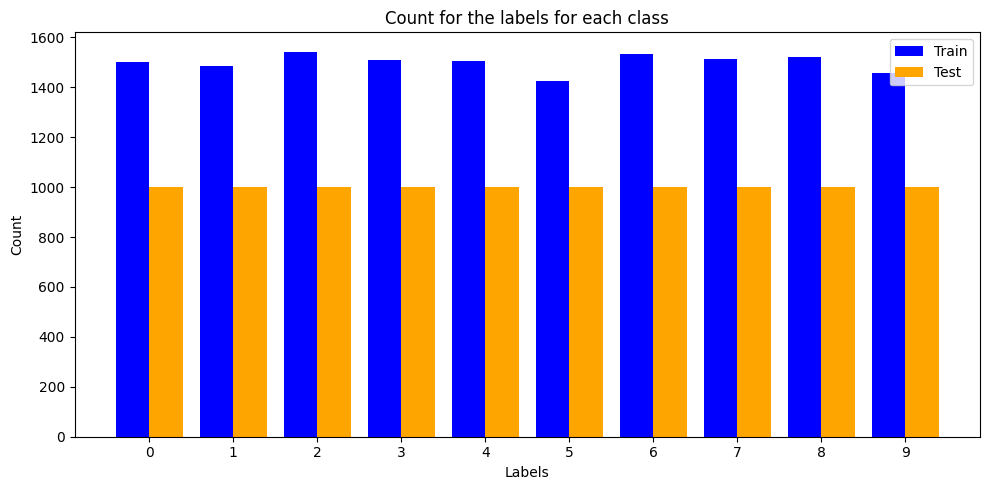

In [17]:
# Count label occurrences
train_counts = pd.Series(train_labels.flatten()).value_counts().sort_index()
test_counts = pd.Series(test_labels.flatten()).value_counts().sort_index()

# Plot label distribution
labels = train_counts.index
x = np.arange(len(labels))
bar_width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x, train_counts, width=bar_width, label='Train', color='blue')
plt.bar(x + bar_width, test_counts, width=bar_width, label='Test', color='orange')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count for the labels for each class')
plt.xticks(x + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.show()

looks reasonable

In [18]:
train_images.shape

(15000, 32, 32, 3)

I see that have 10k 32x32 images that have 3 channels, meaning that these are RGB images. This is for the training portion of data. Testing portion will be the same.

In [19]:
test_images.shape

(10000, 32, 32, 3)

## data overview

build a list that will contain the classes

In [20]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
def plot_image(i):
    image = train_images[i]
    label = train_labels.flatten()[i]

    cl = classes[label]

    plt.imshow(image)
    plt.title(cl)

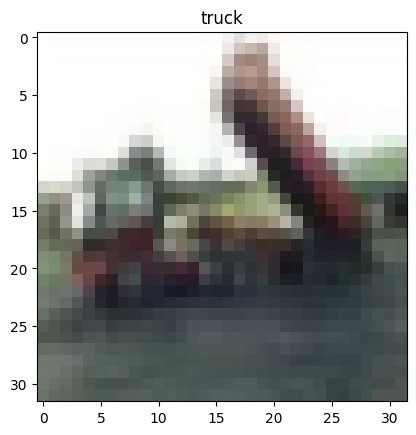

In [22]:
plot_image(2)

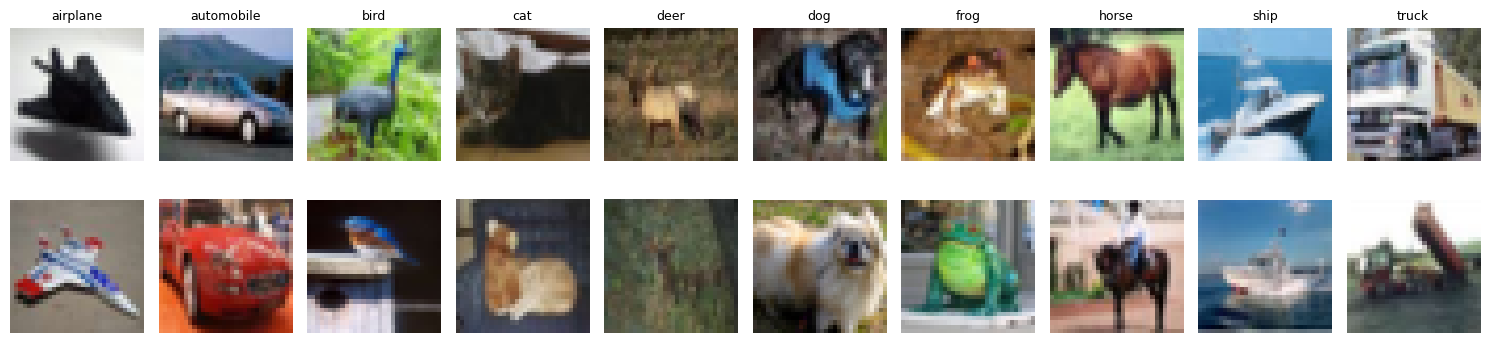

In [23]:
# Flatten labels for indexing
flat_labels = train_labels.flatten()

# Get one example for each class (twice)
top_indices = []
bottom_indices = []

for class_idx in range(10):
    indices = np.where(flat_labels == class_idx)[0]
    top_indices.append(indices[0])       # First image of the class
    bottom_indices.append(indices[1])    # Second image of the class

# Plot 2 rows × 10 columns
plt.figure(figsize=(15, 4))
for col in range(10):
    # Top row (with label)
    plt.subplot(2, 10, col + 1)
    plt.imshow(train_images[top_indices[col]])
    plt.title(classes[col], fontsize=9)
    plt.axis('off')

    # Bottom row (no label)
    plt.subplot(2, 10, 10 + col + 1)
    plt.imshow(train_images[bottom_indices[col]])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model

In [24]:
# Convert images to png (scale from 0 to 1)
train_data=train_data.astype('float32')
test_data=test_data.astype('float32')

train_data/=255
test_data/=255

In [25]:
#Converting labels to one-hot encoding form
from tensorflow.keras.utils import to_categorical

train_labels_one_hot=to_categorical(train_labels)
test_labels_one_hot=to_categorical(test_labels)

In [26]:
print("Before encoding",train_labels[5])
print("After encoding",train_labels_one_hot[5])

Before encoding [1]
After encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


my model

In [27]:
# This is the intended CNN model
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    #The same as before happens here, except the size is kept the same, but again in the end, it is halved
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),

    #The previous layers are repeated again allowing the model to comprehend more complex features, and make identifications regardless of the spatial position
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),

    #This layer flattens the 2D image into a linear form for the next layers
    tf.keras.layers.Flatten(),

    #These layers are the ones responsible for analysing patterns and making predictions from the flattened layer
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    # Ensure the output layer matches the number of classes (10 for CIFAR-10)
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

# Converting labels to one-hot encoding form
# from tensorflow.keras.utils import to_categorical

train_labels_one_hot=to_categorical(train_labels, num_classes=num_classes) # Specify num_classes
test_labels_one_hot=to_categorical(test_labels, num_classes=num_classes)   # Specify num_classes

# Normalize the images by dividing by 255.0
train_images_normalized = train_images.astype('float32') / 255.0
test_images_normalized = test_images.astype('float32') / 255.0


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the unflattened and normalized images
history = model.fit(train_images_normalized, train_labels_one_hot, batch_size=256, epochs=50, verbose=1,
                   validation_data=(test_images_normalized, test_labels_one_hot))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 768ms/step - accuracy: 0.1666 - loss: 2.1752 - val_accuracy: 0.3562 - val_loss: 1.7502
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.3664 - loss: 1.7036 - val_accuracy: 0.4051 - val_loss: 1.5928
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 674ms/step - accuracy: 0.4425 - loss: 1.5497 - val_accuracy: 0.4554 - val_loss: 1.4843
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 682ms/step - accuracy: 0.4756 - loss: 1.4518 - val_accuracy: 0.4600 - val_loss: 1.4770
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 645ms/step - accuracy: 0.4949 - loss: 1.3871 - val_accuracy: 0.4986 - val_loss: 1.3747
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 673ms/step - accuracy: 0.5332 - loss: 1.3019 - val_accuracy: 0.5260 - val_loss: 1.3101
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 675ms/step - accuracy: 0.5685 - loss: 1.2125 - val_accuracy: 0.5554 - val_loss: 1.2238
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 664ms/step - accuracy: 0.6016 - loss: 1.1130 - val_accu

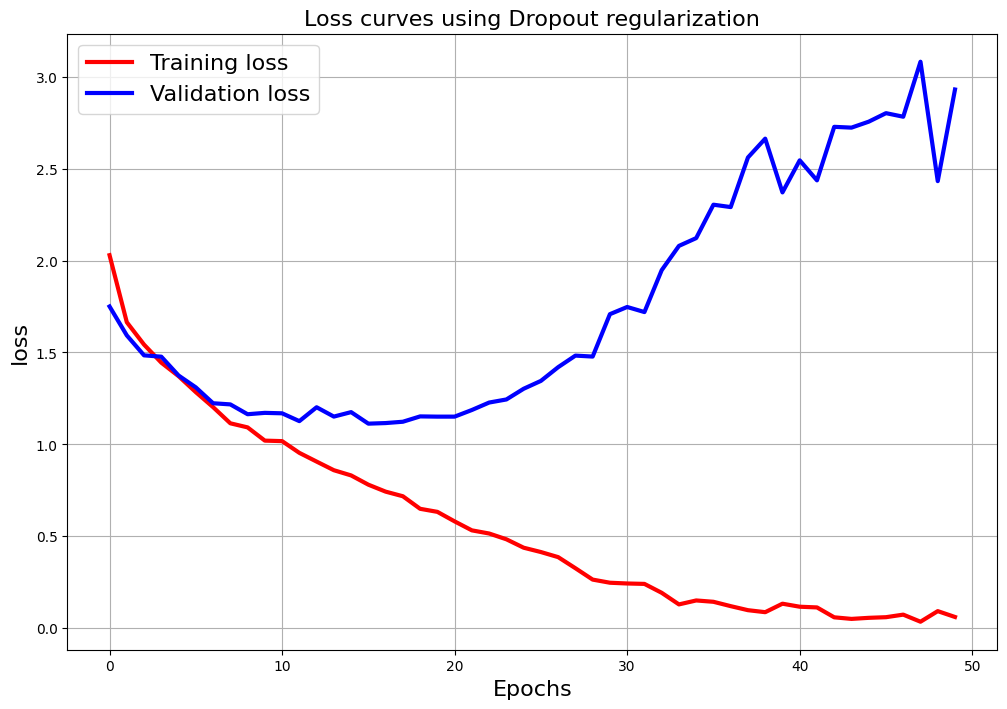

In [30]:
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.title('Loss curves using Dropout regularization',fontsize=16)
plt.grid()

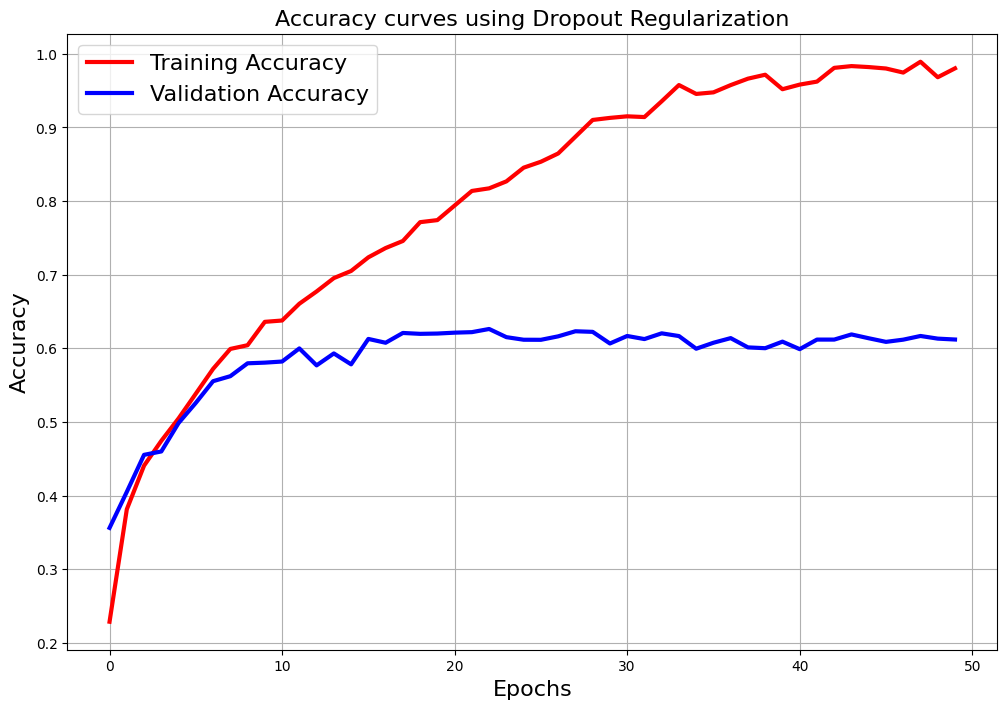

In [31]:
plt.figure(figsize=[12,8])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy curves using Dropout Regularization',fontsize=16)
plt.grid()